## ⭕ Práctica *final* de clasificación

Vamos a retomar el dataset de la sesión pasada (dataset PIMA). El objetivo es tener el mejor modelo posible con cada uno de los siguientes algoritmos:

* SVM
* Decision Tree
* Random Forest
* Regresión Logística

Con esto haremos una comparación entre ellos.

Los pasos a seguir son:

1. Prepara el dataset para los algoritmo, recuerda que hay algunos valores faltantes. Además, recuerda reescalar los datos apropiadamente.

2. Usando como dataset el dataset preprocesado del paso anterior, realiza una busqueda de parámetros con cada algoritmo de acuerdo a las siguientes opciones:

* SVM
 * C: 0.1,1,10,100
 * kernel: lineal, polinomial, rbf
 * grados (polinomial): 2,3,5
* Decision Tree
 * criterion: gini, entropy, log_loss
 * max_depth: None, 10, 20,
 * min_samples_split: 2, 3, 5
* Random Forest
 * criterion: gini, entropy, log_loss
 * max_depth: None, 10, 20,
 * min_samples_split: 2, 3, 5
* Regresión Logística
 * C: 0.1,1,10
 * penalty: l1, l2, elasticnet, None

3. Considerando los 4 mejores modelos anteriores. ¿Qué clasificador tiene mejor rendimiento en este dataset? Para esto toma en cuenta el accuracy en el conjunto de prueba.

### Importación de librerias necesarias

In [19]:
# Importa las bibliotecas necesarias
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import pickle

### Carga del DF

In [20]:
url = 'https://github.com/DCDPUAEM/DCDP/raw/main/03%20Machine%20Learning/data/diabetes.csv'
df = pd.read_csv(url,index_col=0)
df

,pregnant,glucose,bp,skin,insulin,bmi,pedigree,age,label
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


### Analisis Exploratorio de los datos

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   pregnant  768 non-null    int64  
 1   glucose   768 non-null    int64  
 2   bp        768 non-null    int64  
 3   skin      768 non-null    int64  
 4   insulin   768 non-null    int64  
 5   bmi       768 non-null    float64
 6   pedigree  768 non-null    float64
 7   age       768 non-null    int64  
 8   label     768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 60.0 KB


In [27]:
# Verifica las columnas del dataframe
print("Columnas del dataframe:")
df.columns

Columnas del dataframe:


Index(['pregnant', 'glucose', 'bp', 'skin', 'insulin', 'bmi', 'pedigree',
       'age', 'label'],
      dtype='object')

In [28]:
# Calcula estadísticas descriptivas básicas
print("\nEstadísticas descriptivas básicas:")
df.describe()


Estadísticas descriptivas básicas:


,pregnant,glucose,bp,skin,insulin,bmi,pedigree,age,label
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


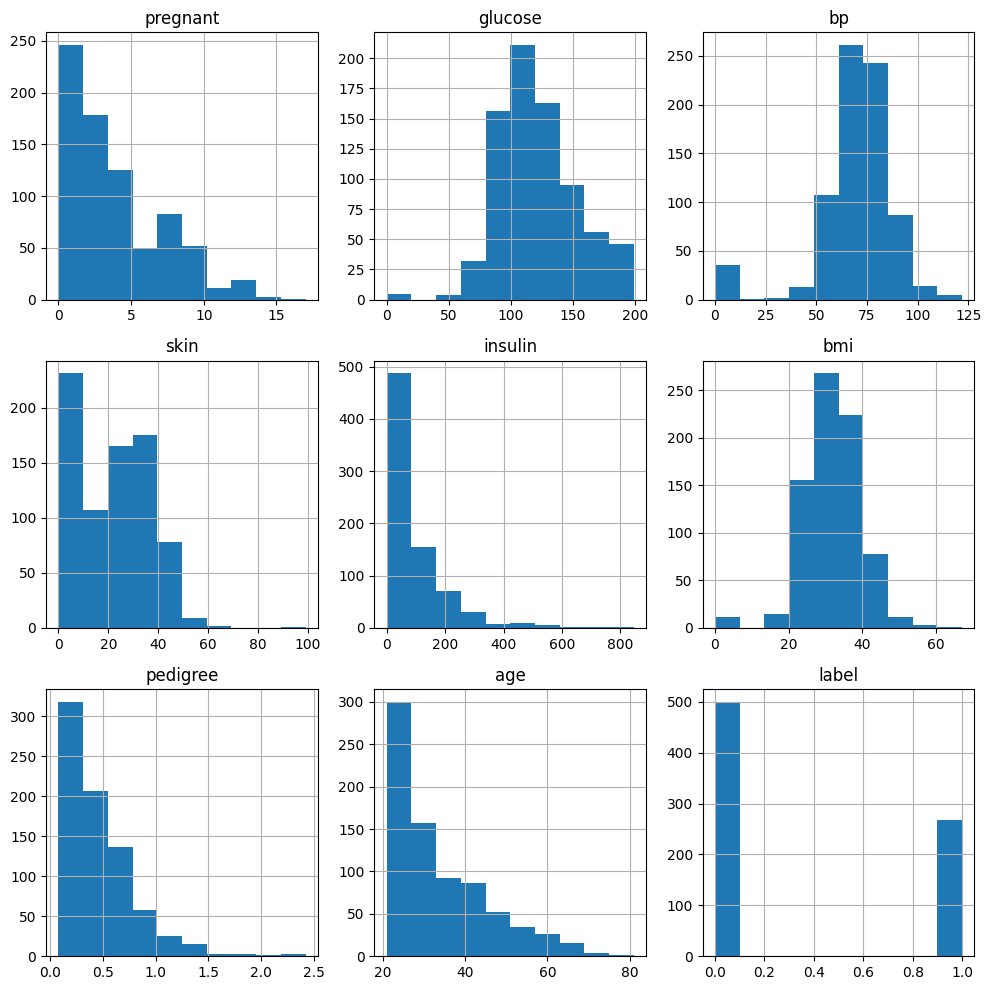

In [29]:
#Distribución de las variables
df.hist(figsize=(10,10))
plt.tight_layout()
plt.show()

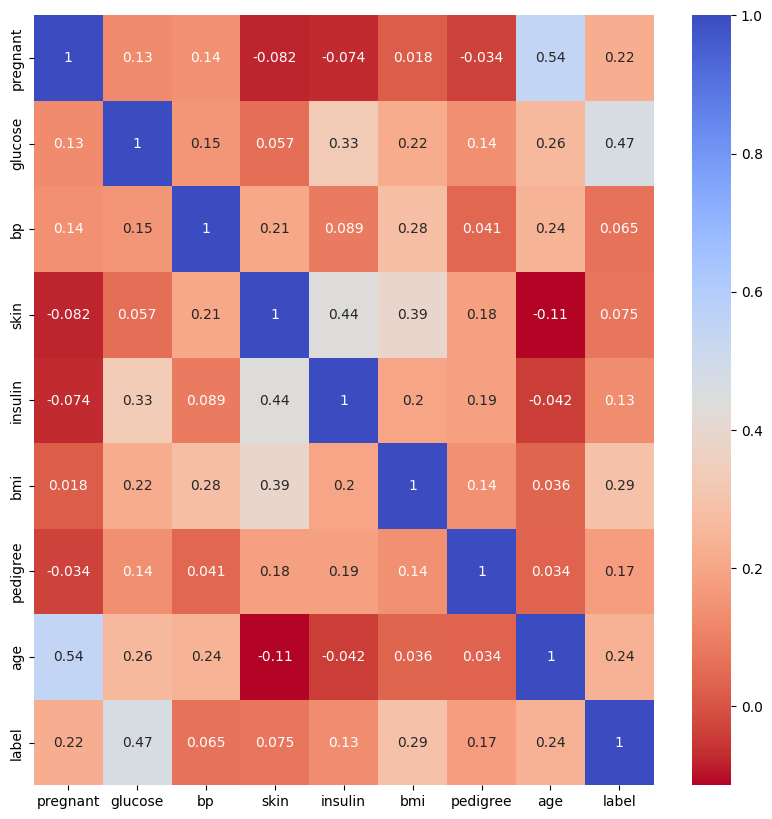

In [30]:
#Matriz de Correlación entre las variables
plt.figure(figsize=(10,10))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm_r')
plt.show()

In [31]:
# Verifica si hay valores faltantes
print(df.isnull().sum())

pregnant    0
glucose     0
bp          0
skin        0
insulin     0
bmi         0
pedigree    0
age         0
label       0
dtype: int64


In [32]:
# Contar los ceros en cada columna
zero_counts = df.apply(lambda col: (col == 0).sum())
print (zero_counts)

pregnant    111
glucose       5
bp           35
skin        227
insulin     374
bmi          11
pedigree      0
age           0
label       500
dtype: int64


Considera los ceros (0) en las columnas Glucose BP, BMI y Skin como valores nulos.

### Impuatción de los datos faltantes

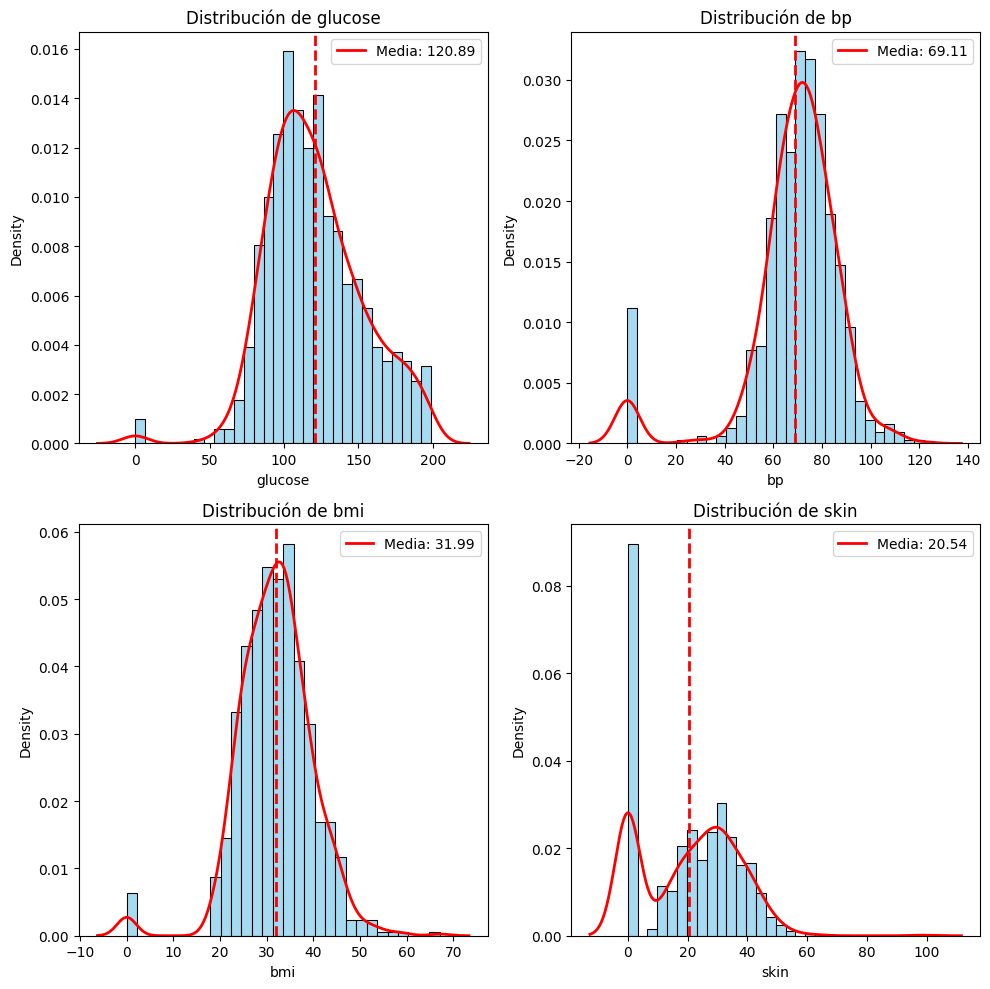

In [33]:
# Lista de columnas
cols = ['glucose', 'bp', 'bmi', 'skin']

fig, axs = plt.subplots(2, 2, figsize=(10,10))
axs = axs.ravel()

for i, col in enumerate(cols):
    data = df[col].dropna()
    sns.histplot(data, bins=30, kde=False, ax=axs[i], color='skyblue', edgecolor='black', stat='density')
    sns.kdeplot(data, color='red', lw=2, ax=axs[i])
    
    axs[i].axvline(data.mean(), color='red', linestyle='dashed', linewidth=2)
    
    axs[i].set_title(f'Distribución de {col}')
    axs[i].legend([f'Media: {data.mean():.2f}'])

plt.tight_layout()
plt.show()


In [44]:
# Crea una copia del DataFrame
df_copy = df.copy()

# Reemplaza los ceros por NaN en las columnas especificadas
cols_replace = ['glucose', 'bp', 'bmi', 'skin']
df_copy[cols_replace] = df_copy[cols_replace].replace(0, np.nan)

# Lista de columnas para imputación de la mediana
cols_median = ['glucose', 'bp', 'bmi']

# Imputación de la mediana
for col in cols_median:
    median = df_copy[col].median()
    df_copy[col] = df_copy[col].fillna(median)
'''
# Imputación de la moda para 'skin'
mode = df_copy['skin'].mode()[0]
df_copy['skin'] = df_copy['skin'].fillna(mode)
'''
# Imputación de la media para 'skin'
mean = df_copy['skin'].mean()
df_copy['skin'] = df_copy['skin'].fillna(mean)


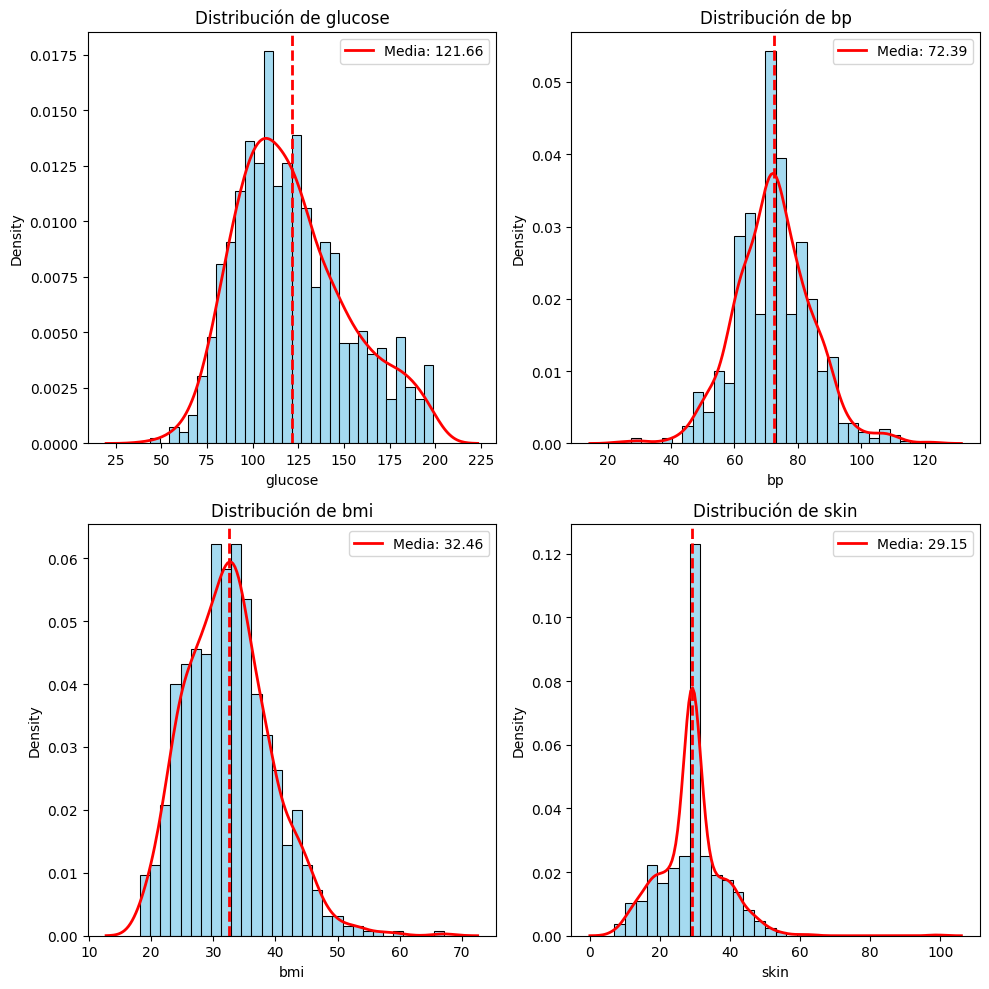

In [45]:
# Lista de columnas
cols = ['glucose', 'bp', 'bmi', 'skin']

fig, axs = plt.subplots(2, 2, figsize=(10,10))
axs = axs.ravel()

for i, col in enumerate(cols):
    data = df_copy[col] 
    sns.histplot(data, bins=30, kde=False, ax=axs[i], color='skyblue', edgecolor='black', stat='density')
    sns.kdeplot(data, color='red', lw=2, ax=axs[i])
    
    axs[i].axvline(data.mean(), color='red', linestyle='dashed', linewidth=2)
    
    axs[i].set_title(f'Distribución de {col}')
    axs[i].legend([f'Media: {data.mean():.2f}'])

plt.tight_layout()
plt.show()

#### Entrenamiento del Modelo

In [46]:
# Divide el dataset en conjuntos de entrenamiento y prueba
X = df_copy.drop('label', axis=1)
y = df_copy['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [47]:
# Crea una instancia del StandardScaler
scaler = StandardScaler()

# Ajusta y transforma los datos de entrenamiento
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)

# Transforma los datos de prueba
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

In [48]:
# Define los parámetros para la búsqueda de cuadrícula
parametros_svm = {'C': [0.1, 1, 10, 100], 'kernel': ['linear', 'poly', 'rbf'], 'degree': [2, 3, 5]}
parametros_dt = {'criterion': ['gini', 'entropy'], 'max_depth': [None, 10, 20], 'min_samples_split': [2, 3, 5]}
parametros_rf = {'criterion': ['gini', 'entropy'], 'max_depth': [None, 10, 20], 'min_samples_split': [2, 3, 5]}
parametros_lr = {'C': [0.1, 1, 10], 'penalty': ['l1', 'l2', 'elasticnet', None]}

# Define los modelos
modelos = [SVC(), DecisionTreeClassifier(), RandomForestClassifier(), LogisticRegression()]
parametros = [parametros_svm, parametros_dt, parametros_rf, parametros_lr]

# Define qué modelos usarán los datos reescalados
usa_datos_reescalados = [True, False, False, True]

for modelo, parametro, usa_reescalado in zip(modelos, parametros, usa_datos_reescalados):
    X_train_usado = X_train_scaled if usa_reescalado else X_train
    X_test_usado = X_test_scaled if usa_reescalado else X_test
    
    grid = GridSearchCV(modelo, parametro, cv=5)
    grid.fit(X_train_usado, y_train)
    
    print(f"Mejores parámetros para {modelo.__class__.__name__}: {grid.best_params_}")
    print(f"Accuracy en el conjunto de prueba: {accuracy_score(y_test, grid.predict(X_test_usado))}")

Mejores parámetros para SVC: {'C': 1, 'degree': 2, 'kernel': 'linear'}
Accuracy en el conjunto de prueba: 0.7597402597402597
Mejores parámetros para DecisionTreeClassifier: {'criterion': 'entropy', 'max_depth': None, 'min_samples_split': 5}
Accuracy en el conjunto de prueba: 0.7272727272727273
Mejores parámetros para RandomForestClassifier: {'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 2}
Accuracy en el conjunto de prueba: 0.7662337662337663


C:\Users\Dark Knight\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Dark Knight\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Dark Knight\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Dark Knight\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Dark Knight\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.w

Mejores parámetros para LogisticRegression: {'C': 0.1, 'penalty': 'l2'}
Accuracy en el conjunto de prueba: 0.7597402597402597


El modelo con el mejor rendimiento en este dataset es el Bosque Aleatorio (Random Forest), con una precisión del 76.62%.
SVC: 75.97%
Árbol de Decisión (Decision Tree): 72.72%
Bosque Aleatorio (Random Forest): 76.62%
Regresión Logística (Logistic Regression): 75.97%

Por lo tanto, el Árbol de Decisión es el clasificador que tiene el mejor rendimiento en este dataset, según la métrica de precisión en el conjunto de prueba.

Mejores parámetros para SVC: {'C': 1, 'degree': 2, 'kernel': 'linear'}
Accuracy en el conjunto de prueba: 0.7597402597402597


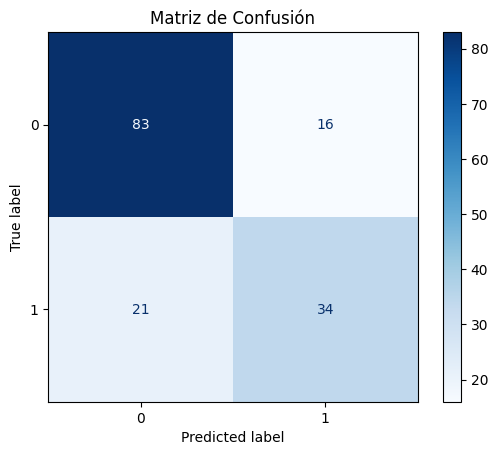

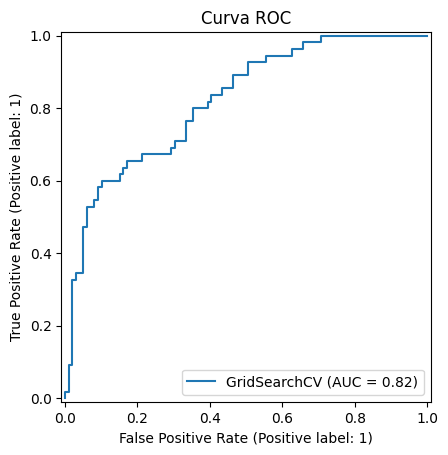

Mejores parámetros para DecisionTreeClassifier: {'criterion': 'entropy', 'max_depth': None, 'min_samples_split': 5}
Accuracy en el conjunto de prueba: 0.7337662337662337


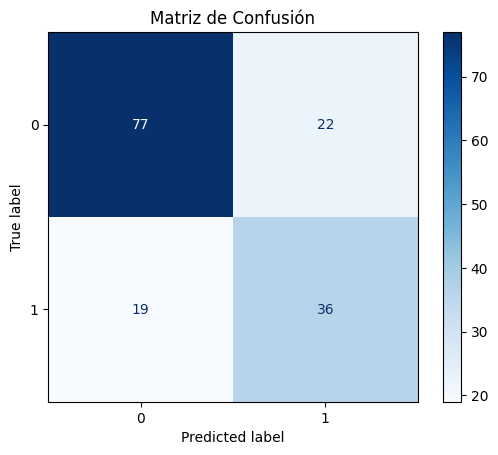

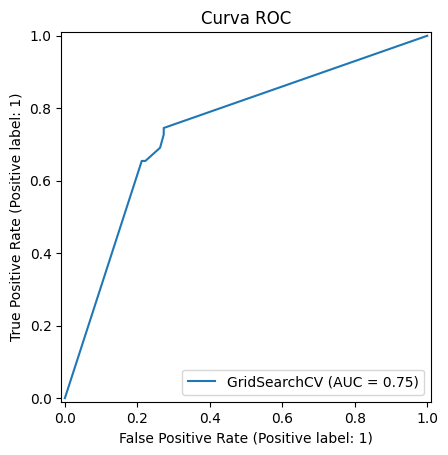

Mejores parámetros para RandomForestClassifier: {'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 2}
Accuracy en el conjunto de prueba: 0.7532467532467533


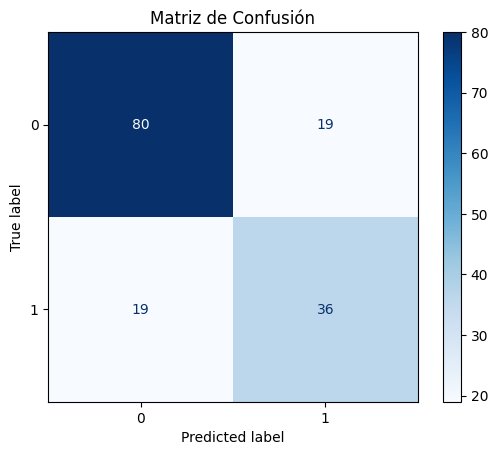

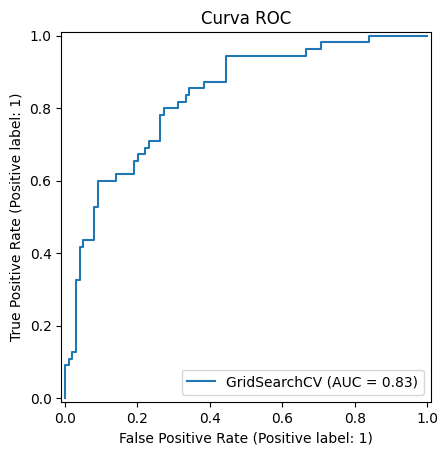

Mejores parámetros para LogisticRegression: {'C': 0.1, 'penalty': 'l2'}
Accuracy en el conjunto de prueba: 0.7597402597402597


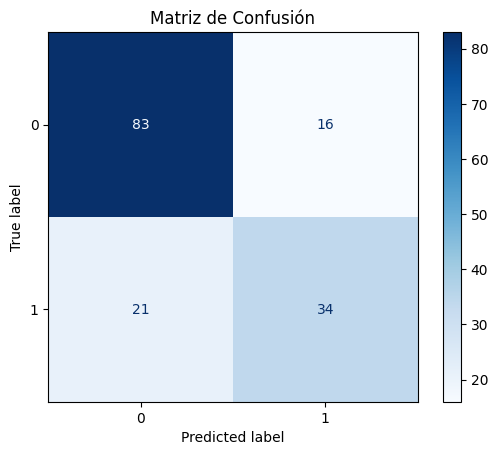

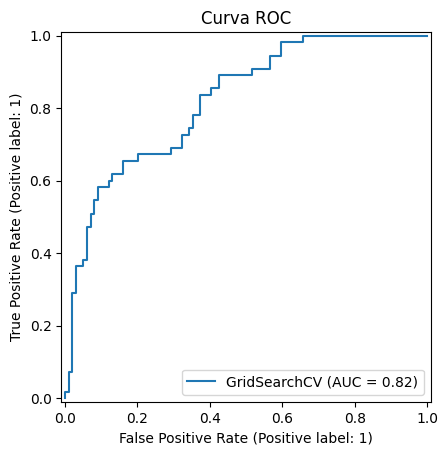

In [71]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import RocCurveDisplay

# Define los modelos
modelos = [SVC(), DecisionTreeClassifier(), RandomForestClassifier(), LogisticRegression()]

# Define manualmente los parámetros para cada modelo
parametros_svm = {'C': [1], 'kernel': ['linear'], 'degree': [2]}
parametros_dt = {'criterion': ['entropy'], 'max_depth': [None], 'min_samples_split': [5]}
parametros_rf = {'criterion': ['gini'], 'max_depth': [10], 'min_samples_split': [2]}
parametros_lr = {'C': [0.1], 'penalty': ['l2']}
parametros = [parametros_svm, parametros_dt, parametros_rf, parametros_lr]

# Define qué modelos usarán los datos reescalados
usa_datos_reescalados = [True, False, False, True]

# Crea un diccionario vacío para guardar los modelos entrenados
modelos_entrenados = {}

# Entrena cada modelo con su respectivo conjunto de datos y parámetros
for modelo, parametro, usa_reescalado in zip(modelos, parametros, usa_datos_reescalados):
    X_train_usado = X_train_scaled if usa_reescalado else X_train
    X_test_usado = X_test_scaled if usa_reescalado else X_test
    
    grid = GridSearchCV(modelo, parametro, cv=5)
    grid.fit(X_train_usado, y_train)

    # Guarda el modelo entrenado en el diccionario
    modelos_entrenados[modelo.__class__.__name__] = grid
    
    print(f"Mejores parámetros para {modelo.__class__.__name__}: {grid.best_params_}")
    print(f"Accuracy en el conjunto de prueba: {accuracy_score(y_test, grid.predict(X_test_usado))}")

    # Grafica la matriz de confusión
    disp = ConfusionMatrixDisplay.from_estimator(grid, X_test_usado, y_test, cmap=plt.cm.Blues)
    plt.title('Matriz de Confusión')
    plt.show()
    
    # Grafica la curva ROC
    roc_disp = RocCurveDisplay.from_estimator(grid, X_test_usado, y_test)
    plt.title('Curva ROC')
    plt.show()


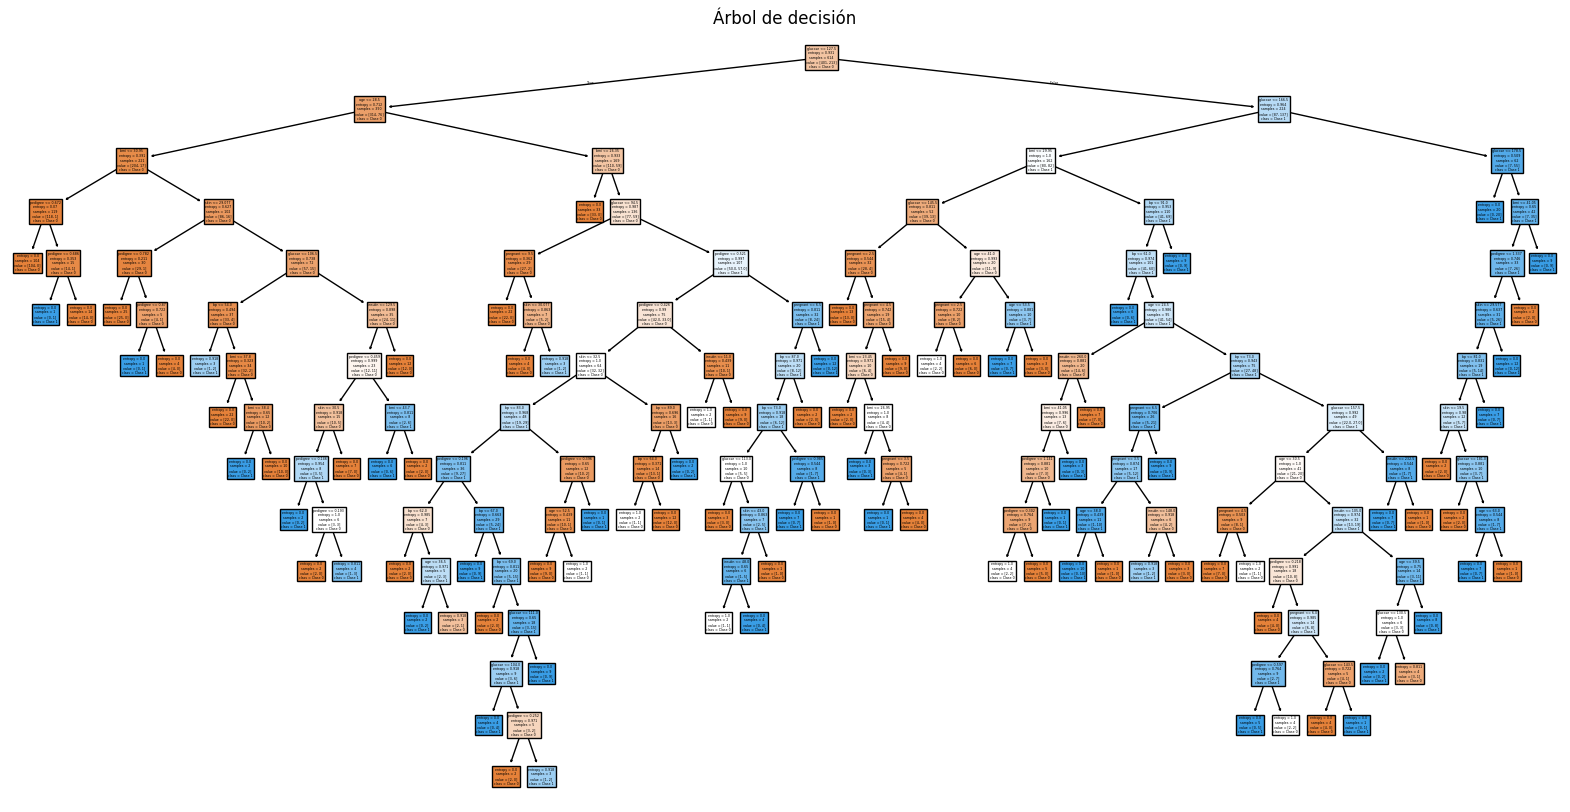

In [75]:
from sklearn.tree import plot_tree

dt = modelos_entrenados['DecisionTreeClassifier'].best_estimator_

# Visualiza el árbol de decisión
plt.figure(figsize=(20,10))
plot_tree(dt, filled=True, feature_names=X_train.columns, class_names=['Clase 0', 'Clase 1'])
plt.title("Árbol de decisión")
plt.show()

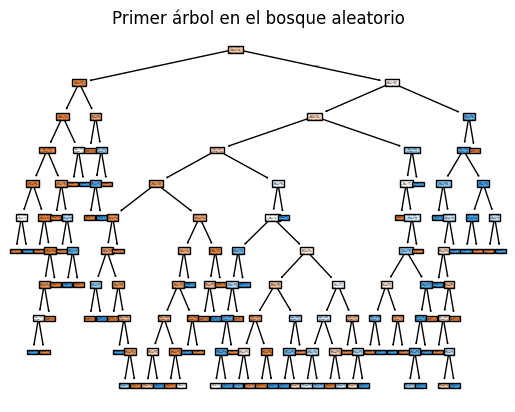

In [76]:
from sklearn.tree import plot_tree

rf = modelos_entrenados['RandomForestClassifier'].best_estimator_

# Visualiza el primer árbol en el bosque
plt.figure()
plot_tree(rf.estimators_[0], filled=True)
plt.title("Primer árbol en el bosque aleatorio")
plt.show()
